# Preliminary operations

In [22]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Set seeds
seed = 123
tf.keras.utils.set_random_seed(seed)

In [23]:
%run utils.ipynb

# Prepare data

In [24]:
event = 'greedy_drivers'
hour = 'day'

In [25]:
# Read normal data
data_path = 'datasets/raw/sf_normal_final_indicators_97200.csv'
df = pd.read_csv(data_path)
number_of_features = len(df.columns)

In [26]:
# Aggregate data by 300 timestamps (5 minutes), using average
for column in df.columns:
    df[column] = np.around(df[column].astype(float), 5)
    df[column] = df[column].rolling(window = 300).mean()
df = df[6900:-1800].reset_index(drop = True)

In [27]:
df.columns

Index(['rides_requested', 'rides_canceled', 'rides_not_served',
       'rides_accepted', 'rides_rejections', 'rides_in_progress',
       'idle_drivers', 'responding_drivers', 'pickup_drivers',
       'on_road_drivers', 'moving_drivers', 'active_customers',
       'pending_customers', 'avg_rejections_before_accepted',
       'avg_surge_multiplier', 'avg_expected_price', 'avg_real_price',
       'avg_diff_price', 'avg_actual_expected_price', 'avg_actual_price',
       'avg_actual_expected_price_30min', 'avg_actual_price_30min',
       'avg_actual_expected_price_60min', 'avg_actual_price_60min',
       'avg_current_error_ride_distance', 'avg_speed_max_speed',
       'avg_speed_kmh', 'avg_diff_duration_min', 'avg_expected_ride_time_min',
       'avg_expected_meeting_time_min', 'avg_expected_total_time_min',
       'avg_ride_time_min', 'avg_meeting_time_min', 'avg_total_time_min',
       'avg_ride_length_km', 'avg_meeting_length_km', 'avg_total_length_km',
       'avg_distance_per_timestamp

The rides not served index could be scaled by the number of rides requested, in order to weight it based on the requests. Specifically, we apply a logarithmic function which scales the rides not served by the number of rides requested, if they are lower than the average rides requested in a normal scenario.

In [28]:
df['rides_requested'][6900:-1800].mean()

1.8763451443569554

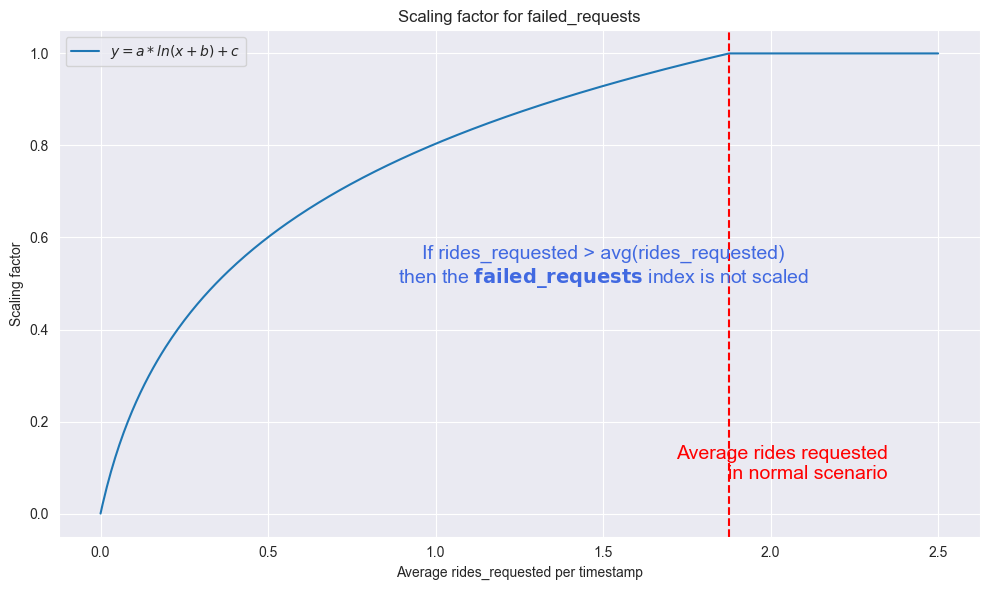

In [29]:
x = np.linspace(0, 2.5, 400)

# Define the values for x1, x2 and their corresponding y values
x1, y1 = 0, 0
x2, y2 = df['rides_requested'][6900:-1800].mean(), 1 
# Adjust b to ensure the function is defined at x = 0
b = 0.1
# Values of ln(x+b) at x1 and x2
ln_x1_b = np.log(x1 + b)
ln_x2_b = np.log(x2 + b)
# System of equations:
# a * ln(0.1) + c = 0
# a * ln(df['rides_requested'].mean()) + c = 1
# We can represent this system as matrix equations A * [a, c] = Y
A = np.array([
    [ln_x1_b, 1],
    [ln_x2_b, 1]
])
Y = np.array([y1, y2])
# Solving for coefficients a and c
coefficients = np.linalg.solve(A, Y)
a, c = coefficients
# Calculate the y values based on the given function
y = np.where(x > df[6900:-1800]['rides_requested'].mean(), 1, (a*np.log(x+b)+c))

# Plotting
plt.figure(figsize = (10, 6))
plt.plot(x, y, label=r'$y=a*ln(x+b)+c$')
plt.title('Scaling factor for failed_requests')
plt.xlabel('Average rides_requested per timestamp')
plt.ylabel('Scaling factor')
plt.axvline(x = df[6900:-1800]['rides_requested'].mean(), color = 'red', linestyle = '--')
plt.annotate('Average rides requested\nin normal scenario', xy = (df['rides_requested'][6900:-1800].mean(), 0), 
             xytext = (2.35, 0.15), horizontalalignment = 'right', verticalalignment = 'top', color = 'red', fontsize = 14)
#plt.text(x = 1.25, y = 0.25, s = "The failed_requests index is scaled \ndepending on the number of rides requested", color = 'royalblue', fontsize = 12, ha = 'center')
plt.text(x = 1.5, y = 0.5, s = "If rides_requested > avg(rides_requested)\nthen the $\mathbf{failed\_requests}$ index is not scaled", color = 'royalblue', fontsize = 14, ha = 'center')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('failed_requests/scaling_factor.png', dpi = 300)
plt.show()

In [30]:
# Read event data
data_path_event = 'datasets/raw/sf_' + event + '_final_indicators_18000_' + hour + '.csv'
df_event = pd.read_csv(data_path_event)
df_event = df_event.drop('timestamp', axis = 1)

In [31]:
# Aggregate data by 300 timestamps (5 minutes), using average
for column in df_event.columns:
    df_event[column] = np.around(df_event[column].astype(float), 5)
    df_event[column] = df_event[column].rolling(window = 300).mean()
df_event = df_event[6900:-1800].reset_index(drop = True)

In [32]:
df_event.columns

Index(['rides_requested', 'rides_canceled', 'rides_not_served',
       'rides_accepted', 'rides_rejections', 'rides_in_progress',
       'idle_drivers', 'responding_drivers', 'pickup_drivers',
       'on_road_drivers', 'moving_drivers', 'active_customers',
       'pending_customers', 'avg_rejections_before_accepted',
       'avg_surge_multiplier', 'avg_expected_price', 'avg_real_price',
       'avg_diff_price', 'avg_actual_expected_price', 'avg_actual_price',
       'avg_actual_expected_price_30min', 'avg_actual_price_30min',
       'avg_actual_expected_price_60min', 'avg_actual_price_60min',
       'avg_current_error_ride_distance', 'avg_speed_max_speed',
       'avg_speed_kmh', 'avg_diff_duration_min', 'avg_expected_ride_time_min',
       'avg_expected_meeting_time_min', 'avg_expected_total_time_min',
       'avg_ride_time_min', 'avg_meeting_time_min', 'avg_total_time_min',
       'avg_ride_length_km', 'avg_meeting_length_km', 'avg_total_length_km',
       'avg_distance_per_timestamp

# Dynamic greediness

We compute the dynamic greediness curves, in order to have a clearer view of the events.

In [33]:
df_event_dynamic = pd.read_csv(data_path_event)
df_event_dynamic = df_event_dynamic.drop('timestamp', axis = 1)
for column in df_event_dynamic.columns:
    df_event_dynamic[column] = np.around(df_event_dynamic[column].astype(float), 5)
    df_event_dynamic[column] = df_event_dynamic[column].rolling(window = 300).mean()
df_event_dynamic['tot_drivers'] = df_event_dynamic['idle_drivers'] + df_event_dynamic['moving_drivers']
df_event_dynamic['ratio_cust_driv'] = df_event_dynamic['pending_customers']/df_event_dynamic['tot_drivers']
df_event_dynamic = df_event_dynamic[6900:-1800].reset_index(drop = True)

df_event_roll = pd.read_csv(data_path_event)
df_event_roll = df_event_roll.drop('timestamp', axis = 1)
for column in df_event_roll.columns:
    df_event_roll[column] = np.around(df_event_roll[column].astype(float), 5)
    df_event_roll[column] = df_event_roll[column].rolling(window = 1800).mean()
df_event_roll['tot_drivers'] = df_event_roll['idle_drivers'] + df_event_roll['moving_drivers']
df_event_roll['ratio_cust_driv'] = df_event_roll['pending_customers']/df_event_roll['tot_drivers']
df_event_roll = df_event_roll[6900:-1800].reset_index(drop = True)

df_event_dynamic['ratio_cust_driv_surge'] = (df_event_dynamic['ratio_cust_driv'] - df_event_roll['ratio_cust_driv']) / (df_event_dynamic['avg_surge_multiplier'])

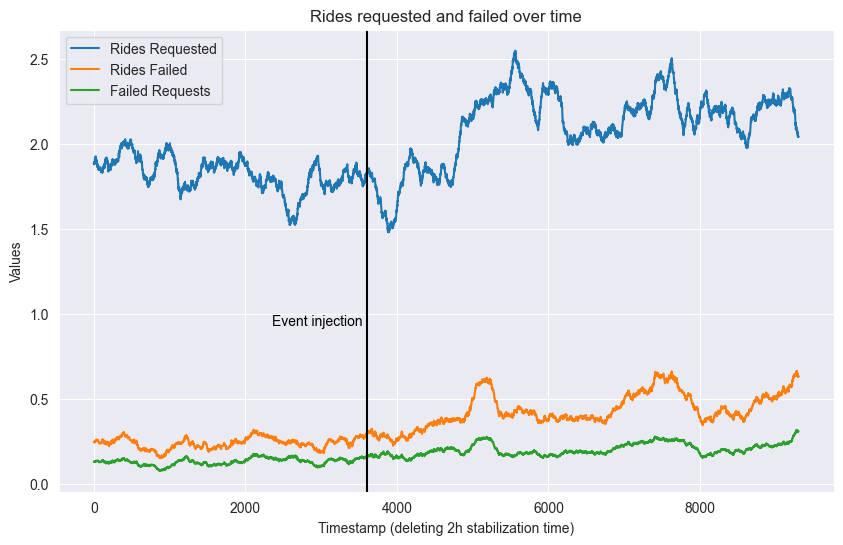

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(df_event_dynamic['rides_requested'], label = 'Rides Requested')
plt.plot((df_event_dynamic['rides_not_served']+df_event_dynamic['rides_canceled']), label = 'Rides Failed')
plt.plot((df_event_dynamic['rides_not_served']+df_event_dynamic['rides_canceled'])/df_event_dynamic['rides_requested'], label = 'Failed Requests')
plt.axvline(x = 3600, color = 'k')
plt.annotate('Event injection', xy = (3600, 1), 
             xytext = (3550, 1), horizontalalignment = 'right', verticalalignment = 'top', 
             color = 'k', fontsize = 10)
plt.title('Rides requested and failed over time')
plt.xlabel('Timestamp (deleting 2h stabilization time)')
plt.ylabel('Values')
plt.legend()
plt.show()

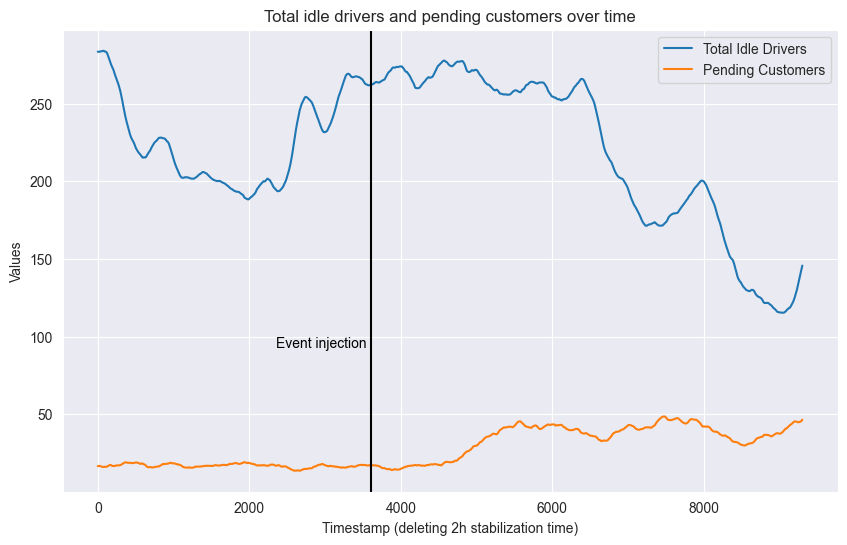

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(df_event_dynamic['tot_drivers'], label='Total Idle Drivers')
plt.plot(df_event_dynamic['pending_customers'], label='Pending Customers')
plt.axvline(x = 3600, color = 'k')
plt.annotate('Event injection', xy = (3600, 100), 
             xytext = (3550, 100), horizontalalignment = 'right', verticalalignment = 'top', 
             color = 'k', fontsize = 10)
plt.title('Total idle drivers and pending customers over time')
plt.xlabel('Timestamp (deleting 2h stabilization time)')
plt.ylabel('Values')
plt.legend()
plt.show()

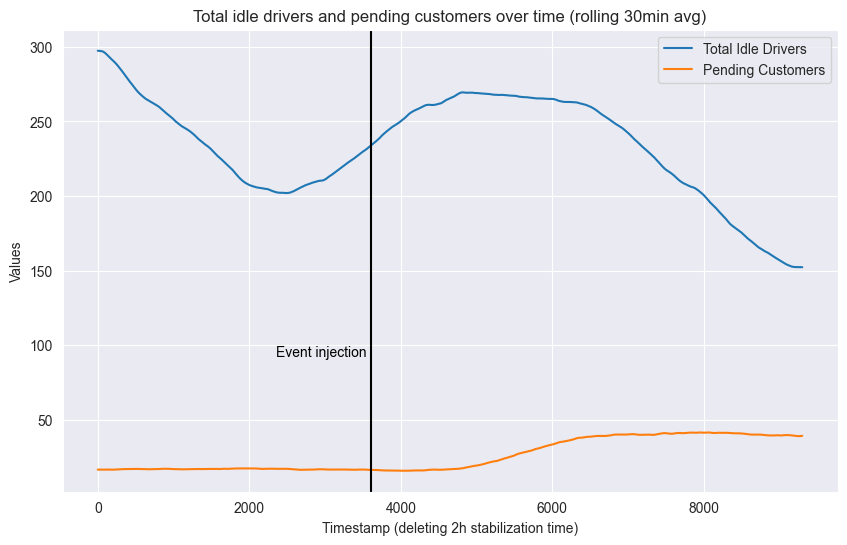

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(df_event_roll['tot_drivers'], label='Total Idle Drivers')
plt.plot(df_event_roll['pending_customers'], label='Pending Customers')
plt.axvline(x=3600, color='k')
plt.annotate('Event injection', xy=(3600, 100),
             xytext=(3550, 100), horizontalalignment='right', verticalalignment='top',
             color='k', fontsize=10)
plt.title('Total idle drivers and pending customers over time (rolling 30min avg)')
plt.xlabel('Timestamp (deleting 2h stabilization time)')
plt.ylabel('Values')
plt.legend()
plt.show()

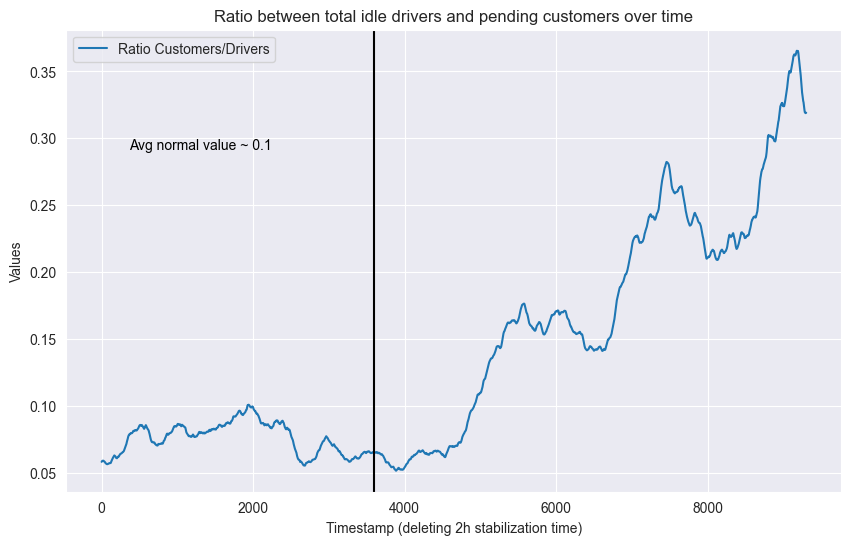

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(df_event_dynamic['ratio_cust_driv'], label='Ratio Customers/Drivers')
plt.axvline(x = 3600, color = 'k')
plt.annotate('Event injection', xy = (3600, 1), 
             xytext = (3550, 1), horizontalalignment = 'right', verticalalignment = 'top', 
             color = 'k', fontsize = 10)
plt.annotate('Avg normal value ~ 0.1', xy = (1300, 0.3), 
             xytext = (1300, 0.3), horizontalalignment = 'center', verticalalignment = 'top', 
             color = 'k', fontsize = 10)
plt.title('Ratio between total idle drivers and pending customers over time')
plt.xlabel('Timestamp (deleting 2h stabilization time)')
plt.ylabel('Values')
plt.legend()
plt.show()

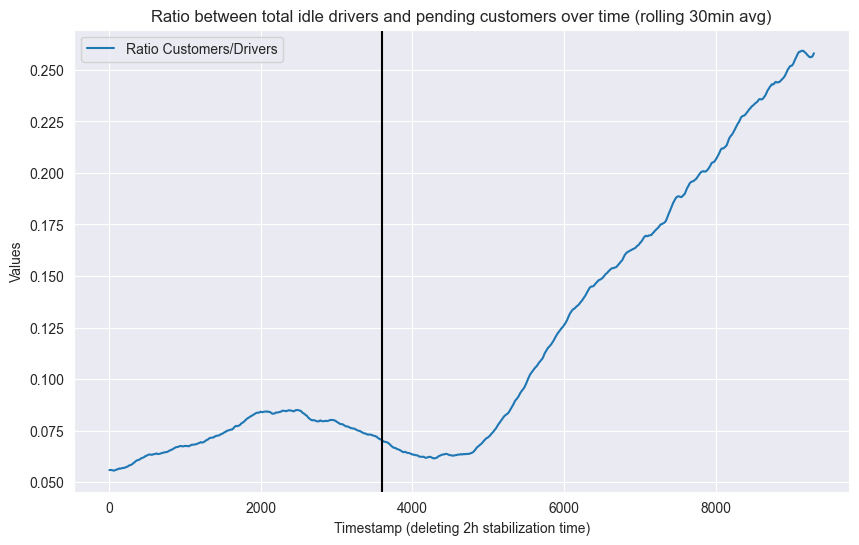

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(df_event_roll['ratio_cust_driv'], label='Ratio Customers/Drivers')
plt.axvline(x = 3600, color = 'k')
plt.annotate('Event injection', xy = (3600, 0.7),
             xytext = (3550, 0.7), horizontalalignment = 'right', verticalalignment = 'top', 
             color = 'k', fontsize = 10)
plt.title('Ratio between total idle drivers and pending customers over time (rolling 30min avg)')
plt.xlabel('Timestamp (deleting 2h stabilization time)')
plt.ylabel('Values')
plt.legend()
plt.show()

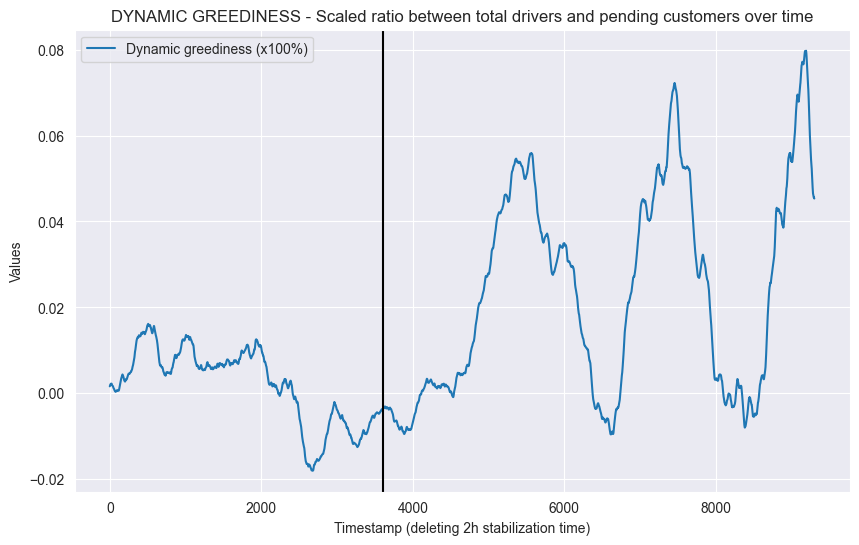

In [40]:
plt.figure(figsize=(10, 6))
plt.plot(df_event_dynamic['ratio_cust_driv_surge'], label='Dynamic greediness (x100%)')
plt.axvline(x = 3600, color = 'k')
plt.annotate('Event injection', xy = (3600, 0.1),
             xytext = (3550, 0.1), horizontalalignment = 'right', verticalalignment = 'top', 
             color = 'k', fontsize = 10)
plt.title('DYNAMIC GREEDINESS - Scaled ratio between total drivers and pending customers over time')
plt.xlabel('Timestamp (deleting 2h stabilization time)')
plt.ylabel('Values')
plt.legend()
plt.show()

We may also compute dynamic greediness on training data to see its behavior in a normal situation.

In [42]:
df_dynamic = pd.read_csv(data_path)
for column in df_dynamic.columns:
    df_dynamic[column] = np.around(df_dynamic[column].astype(float), 5)
    df_dynamic[column] = df_dynamic[column].rolling(window = 600).mean()
df_dynamic = df_dynamic[6900:-1800].reset_index(drop = True)
df_dynamic['tot_drivers'] = df_dynamic['idle_drivers'] + df_dynamic['moving_drivers']
df_dynamic['ratio_cust_driv'] = df_dynamic['pending_customers']/df_dynamic['tot_drivers']

df_roll = pd.read_csv(data_path)
for column in df_roll.columns:
    df_roll[column] = np.around(df_roll[column].astype(float), 5)
    df_roll[column] = df_roll[column].rolling(window = 1800).mean()
df_roll = df_roll[6900:-1800].reset_index(drop = True)
df_roll['tot_drivers'] = df_roll['idle_drivers'] + df_roll['moving_drivers']
df_roll['ratio_cust_driv'] = df_roll['pending_customers']/df_roll['tot_drivers']

df_dynamic['ratio_cust_driv_surge'] = (df_dynamic['ratio_cust_driv'] - df_roll['ratio_cust_driv']) / (df_dynamic['avg_surge_multiplier'])

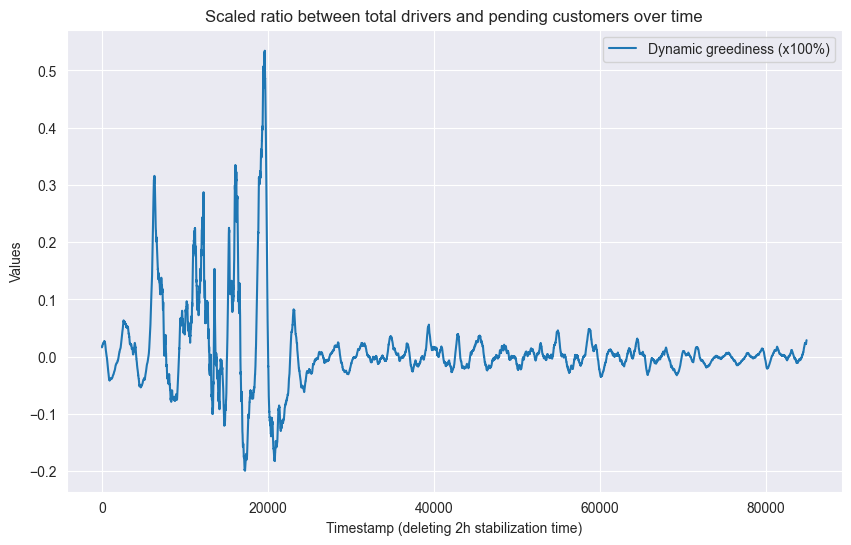

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(df_dynamic['ratio_cust_driv_surge'], label='Dynamic greediness (x100%)')
plt.title('Scaled ratio between total drivers and pending customers over time')
plt.xlabel('Timestamp (deleting 2h stabilization time)')
plt.ylabel('Values')
plt.legend()
plt.show()